<a href="https://colab.research.google.com/github/OverfitSurvivor/code/blob/main/drone_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile

zip_path = "/content/drive/MyDrive/ICSV31AIChallengeDataset.zip"  # 업로드한 ZIP 파일 경로
extract_path = "/content/ICSV31AIChallengeDataset"  # 압축을 풀 폴더 경로

# 폴더가 없으면 생성
os.makedirs(extract_path, exist_ok=True)

# 압축 해제
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료:", extract_path)

압축 해제 완료: /content/ICSV31AIChallengeDataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 모듈 불러오기

In [ ]:
import csv
import argparse
import os
from typing import Any, List, Tuple

import torch
import torchaudio
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

## 라벨링 및 데이터셋 로더

In [ ]:
#######################
# 1. Utils
#######################
def read_csv(file_path: str) -> List:
    with open(file_path, "r") as f:
        reader = csv.reader(f)
        return list(reader)

def save_csv(save_data: List[Any], save_file_path: str) -> None:
    with open(save_file_path, "w", newline="") as f:
        writer = csv.writer(f, lineterminator="\n")
        writer.writerows(save_data)

def get_anomaly_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    train_mode = file_name.split("_")[0]
    if train_mode == "test":
        return -1
    elif "normal" in file_name:
        return 0
    else:
        return 1

def get_drone_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    drone_mode = file_name.split("_")[1]
    if drone_mode == "A":
        return 0
    elif drone_mode == "B":
        return 1
    elif drone_mode == "C":
        return 2
    else:
        return -1

def get_direction_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    direction_mode = file_name.split("_")[2]
    if direction_mode == "Back":
        return 0
    elif direction_mode == "Front":
        return 1
    elif direction_mode == "Left":
        return 2
    elif direction_mode == "Right":
        return 3
    elif direction_mode == "Clockwise":
        return 4
    elif direction_mode == "CounterClockwise":
        return 5
    else:
        return -1

#######################
# 2. Feature Extraction & Augmentation
#######################
def wav_to_log_stft(
    wav_path: str,
    sr: int,
    n_fft: int,
    win_length: int,
    hop_length: int,
    power: float,
) -> torch.Tensor:
    stft_transform = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=power
    )
    wav_data, _ = torchaudio.load(wav_path)
    spec = stft_transform(wav_data)
    amp_to_db = torchaudio.transforms.AmplitudeToDB()
    log_spec = amp_to_db(spec)
    log_spec = (log_spec - log_spec.mean()) / (log_spec.std() + 1e-9)
    return log_spec

def augment_spec(spec: torch.Tensor) -> torch.Tensor:
    max_shift = int(spec.shape[-1] * 0.05)
    shift = torch.randint(-max_shift, max_shift + 1, (1,)).item()
    spec = torch.roll(spec, shifts=shift, dims=-1)
    time_mask_param = max(1, int(spec.shape[-1] * 0.05))
    time_mask = torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param)
    spec = time_mask(spec)
    freq_mask_param = max(1, int(spec.shape[-2] * 0.05))
    freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param)
    spec = freq_mask(spec)
    return spec

#######################
# 3. Dataset
#######################
class BaselineDataLoader(Dataset):
    def __init__(
        self,
        file_list: List[str],
        sr: int,
        n_fft: int,
        win_length: int,
        hop_length: int,
        power: float,
        augment: bool = False
    ) -> None:
        self.file_list = file_list
        self.sr = sr
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.power = power
        self.augment = augment

    def __len__(self) -> int:
        return len(self.file_list)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, int, int]:
        wav_path = self.file_list[idx]
        spec = wav_to_log_stft(wav_path, self.sr, self.n_fft, self.win_length, self.hop_length, self.power)
        if self.augment:
            spec = augment_spec(spec)
        anomaly_label = get_anomaly_label(wav_path)
        drone_label = get_drone_label(wav_path)
        direction_label = get_direction_label(wav_path)
        return spec, anomaly_label, drone_label, direction_label

def get_train_loader(args: argparse.Namespace, pin_memory: bool = False, num_workers: int = 0) -> DataLoader:
    file_list = sorted(os.listdir(args.train_dir))
    file_list = [os.path.join(args.train_dir, f) for f in file_list if get_anomaly_label(f) == 0]
    dataset = BaselineDataLoader(
        file_list,
        sr=args.sr,
        n_fft=args.n_fft,
        win_length=args.win_length,
        hop_length=args.hop_length,
        power=args.power,
        augment=True
    )
    return DataLoader(dataset, batch_size=args.batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory,
                      persistent_workers=True, prefetch_factor=2)

def get_eval_loader(args: argparse.Namespace, pin_memory: bool = False, num_workers: int = 0) -> Tuple[DataLoader, List[str]]:
    file_list = sorted(os.listdir(args.eval_dir))
    file_list = [os.path.join(args.eval_dir, f) for f in file_list]
    dataset = BaselineDataLoader(
        file_list,
        sr=args.sr,
        n_fft=args.n_fft,
        win_length=args.win_length,
        hop_length=args.hop_length,
        power=args.power,
        augment=False
    )
    return DataLoader(dataset, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory,
                      persistent_workers=True, prefetch_factor=2), file_list

## 모델 학습 및 평가

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse, os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics

#######################
# Utility: 크기 맞춤 함수
#######################
def match_size(source: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    src_h, src_w = source.size(2), source.size(3)
    tgt_h, tgt_w = target.size(2), target.size(3)
    # source가 target보다 크면 center crop
    if src_h > tgt_h or src_w > tgt_w:
        start_h = (src_h - tgt_h) // 2
        start_w = (src_w - tgt_w) // 2
        source = source[:, :, start_h:start_h+tgt_h, start_w:start_w+tgt_w]
    # source가 target보다 작으면 pad
    elif src_h < tgt_h or src_w < tgt_w:
        diff_h = tgt_h - src_h
        diff_w = tgt_w - src_w
        source = F.pad(source, (diff_w // 2, diff_w - diff_w // 2,
                                diff_h // 2, diff_h - diff_h // 2))
    return source

#######################
# 기본 모듈: Residual Block, Encoder, Decoder
#######################
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.05):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # 입력과 출력의 채널 수 또는 stride가 다르면 다운샘플링 적용
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = nn.Identity()

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.05):
        super(EncoderBlock, self).__init__()
        self.resblock = ResidualBlock(in_channels, out_channels, stride=2, dropout=dropout)
    def forward(self, x):
        return self.resblock(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.05):
        super(DecoderBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3,
                                         stride=2, padding=1, output_padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        # Concat 후 채널 수가 2배가 되므로 이를 반영하여 ResidualBlock 구성
        self.resblock = ResidualBlock(out_channels * 2, out_channels, stride=1, dropout=dropout)

    def forward(self, x, skip):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        skip = match_size(skip, x)
        x = torch.cat([x, skip], dim=1)
        x = self.resblock(x)
        return x

#######################
# Transformer Bottleneck 모듈
#######################
class TransformerBottleneck(nn.Module):
    def __init__(self, channels, num_heads=4, num_layers=2):
        """
        channels: feature map의 채널 수 (예: 512)
        num_heads: self-attention 헤드 수
        num_layers: Transformer Encoder Layer 수
        """
        super(TransformerBottleneck, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=channels, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        # x shape: (B, C, H, W)
        B, C, H, W = x.shape
        # 공간 차원을 flatten: (B, C, H*W)
        x = x.flatten(2)  # (B, C, H*W)
        # Transformer는 (seq_len, batch, features) 형태를 요구하므로 transpose
        x = x.transpose(1, 2).transpose(0, 1)  # (H*W, B, C)
        x = self.transformer_encoder(x)          # (H*W, B, C)
        # 원래 형태로 복원: (B, C, H*W)
        x = x.transpose(0, 1).transpose(1, 2)
        # 다시 (B, C, H, W)로 reshape
        x = x.view(B, C, H, W)
        return x

#######################
# Transformer 기반 Denoising Autoencoder (DAE)
#######################
class TransformerDenoisingAutoencoder(nn.Module):
    def __init__(self, input_channels=1, dropout=0.05, transformer_heads=4, transformer_layers=2):
        super(TransformerDenoisingAutoencoder, self).__init__()
        self.enc1 = EncoderBlock(input_channels, 32, dropout)
        self.enc2 = EncoderBlock(32, 64, dropout)
        self.enc3 = EncoderBlock(64, 128, dropout)
        self.enc4 = EncoderBlock(128, 256, dropout)
        self.enc5 = EncoderBlock(256, 512, dropout)
        # Transformer bottleneck: 전역적 관계 학습
        self.transformer_bottleneck = TransformerBottleneck(512, num_heads=transformer_heads, num_layers=transformer_layers)
        self.dec5 = DecoderBlock(512, 256, dropout)
        self.dec4 = DecoderBlock(256, 128, dropout)
        self.dec3 = DecoderBlock(128, 64, dropout)
        self.dec2 = DecoderBlock(64, 32, dropout)
        self.dec1 = nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2,
                                       padding=1, output_padding=1)
    def forward(self, x):
        e1 = self.enc1(x)  # (B, 32, H/2, W/2)
        e2 = self.enc2(e1)  # (B, 64, H/4, W/4)
        e3 = self.enc3(e2)  # (B, 128, H/8, W/8)
        e4 = self.enc4(e3)  # (B, 256, H/16, W/16)
        e5 = self.enc5(e4)  # (B, 512, H/32, W/32)
        # Transformer bottleneck 적용
        t = self.transformer_bottleneck(e5)  # (B, 512, H/32, W/32)
        d5 = self.dec5(t, e4)
        d4 = self.dec4(d5, e3)
        d3 = self.dec3(d4, e2)
        d2 = self.dec2(d3, e1)
        d1 = self.dec1(d2)
        d1 = F.interpolate(d1, size=x.shape[2:], mode="bilinear", align_corners=False)
        return d1

def TransformerDAEModel(dropout) -> nn.Module:
    return TransformerDenoisingAutoencoder(input_channels=1, dropout=dropout)

#######################
# 5. Train & Evaluate
#######################
def get_args() -> argparse.Namespace:
    param = {
        "train_dir": "/content/ICSV31AIChallengeDataset/train",
        "eval_dir": "/content/ICSV31AIChallengeDataset/eval",
        "result_dir": "/content/drive/MyDrive",
        "model_dir": "/content/drive/MyDrive",
        "model_path": "model_transformer_dae.pth",  # 모델 저장 파일명을 변경
        "epochs": 150,
        "batch_size": 32,
        "lr": 0.001,
        "gpu": 0,
        "n_workers": 2,
        "sr": 16000,
        "n_fft": 2048,
        "win_length": 512,
        "hop_length": 512,
        "power": 2.0,
        "early_stopping_patience": 10,
        "min_lr": 1e-6,
        "noise_factor": 0.2,
        "dropout": 0.05
    }
    parser = argparse.ArgumentParser()
    for key, value in param.items():
        parser.add_argument(f"--{key.replace('_', '-')}", default=value, type=type(value))
    args, unknown = parser.parse_known_args()
    return args

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def train_and_evaluate(args: argparse.Namespace) -> None:
    print("Training started...")
    os.makedirs(args.result_dir, exist_ok=True)
    os.makedirs(args.model_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # GPU 최적화를 위한 cudnn benchmark 활성화
    if device.type == "cuda":
        torch.backends.cudnn.benchmark = True

    # Transformer 기반 모델 사용
    model = TransformerDAEModel(dropout=args.dropout).to(device)

    # Model summary 출력 (옵션)
    try:
        from torchsummary import summary
        summary(model, input_size=(1, 256, 256))
    except ImportError:
        print(model)

    train_loader = get_train_loader(args, pin_memory=True, num_workers=args.n_workers)

    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs, eta_min=args.min_lr)
    criterion = nn.MSELoss()

    best_loss = float('inf')
    epochs_no_improve = 0
    epoch_losses = []
    scaler = torch.amp.GradScaler(device='cuda')

    for epoch in range(args.epochs):
        model.train()
        total_loss = 0.0
        count = 0
        p_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{args.epochs}", ncols=100)
        for data in p_bar:
            spec = data[0].to(device)
            noisy_spec = spec + args.noise_factor * torch.randn_like(spec)
            optimizer.zero_grad()

            # Automatic Mixed Precision (AMP) 적용
            with torch.amp.autocast('cuda'):
                decoded = model(noisy_spec)
                loss = criterion(decoded, spec)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            count += 1
            p_bar.set_description(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

        avg_loss = total_loss / count
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")
        scheduler.step()

        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), os.path.join(args.model_dir, args.model_path))
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= args.early_stopping_patience:
                print("Early stopping triggered.")
                break

    print("Training completed.")
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss per Epoch (Transformer DAE)")
    plt.grid(True)
    plt.show()

    print("Evaluation started...")
    model.load_state_dict(torch.load(os.path.join(args.model_dir, args.model_path), map_location=device))
    model.eval()
    # get_eval_loader 함수는 별도로 구현되어야 합니다.
    eval_loader, file_list = get_eval_loader(args, pin_memory=True, num_workers=args.n_workers)
    y_true, y_pred = [], []
    for idx, data in enumerate(eval_loader):
        spec = data[0].to(device)
        anomaly_label = data[1]
        with torch.no_grad():
            decoded = model(spec)
        loss = criterion(decoded, spec)
        y_true.append(1 if anomaly_label.item() > 0 else 0)
        y_pred.append(loss.item())
    auc = metrics.roc_auc_score(y_true, y_pred)
    print("Evaluation AUC:", auc)

Training started...
Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]              64
       BatchNorm2d-2         [-1, 32, 128, 128]              64
            Conv2d-3         [-1, 32, 128, 128]             320
       BatchNorm2d-4         [-1, 32, 128, 128]              64
         LeakyReLU-5         [-1, 32, 128, 128]               0
           Dropout-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]           9,248
       BatchNorm2d-8         [-1, 32, 128, 128]              64
         LeakyReLU-9         [-1, 32, 128, 128]               0
    ResidualBlock-10         [-1, 32, 128, 128]               0
     EncoderBlock-11         [-1, 32, 128, 128]               0
           Conv2d-12           [-1, 64, 64, 64]           2,112
      BatchNorm2d-13           [-1, 64, 64, 64]             128


<ipython-input-8-375e58bfeb75>:203: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/150:   0%|                                                          | 0/169 [00:00<?, ?it/s]<ipython-input-8-375e58bfeb75>:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1, Loss: 0.2407: 100%|██████████████████████████████████████| 169/169 [00:30<00:00,  5.60it/s]


Epoch 1 average loss: 0.3112


Epoch 2, Loss: 0.1789: 100%|██████████████████████████████████████| 169/169 [00:25<00:00,  6.57it/s]


Epoch 2 average loss: 0.2068


Epoch 3, Loss: 0.1252: 100%|██████████████████████████████████████| 169/169 [00:25<00:00,  6.65it/s]


Epoch 3 average loss: 0.1486


Epoch 4, Loss: 0.1063: 100%|██████████████████████████████████████| 169/169 [00:24<00:00,  6.77it/s]


Epoch 4 average loss: 0.1168


Epoch 5, Loss: 0.0961: 100%|██████████████████████████████████████| 169/169 [00:25<00:00,  6.66it/s]


Epoch 5 average loss: 0.1018


Epoch 6, Loss: 0.0836: 100%|██████████████████████████████████████| 169/169 [00:24<00:00,  6.97it/s]


Epoch 6 average loss: 0.0918


Epoch 7, Loss: 0.0736: 100%|██████████████████████████████████████| 169/169 [00:25<00:00,  6.55it/s]


Epoch 7 average loss: 0.0845


Epoch 8, Loss: 0.0778: 100%|██████████████████████████████████████| 169/169 [00:25<00:00,  6.50it/s]


Epoch 8 average loss: 0.0794


Epoch 9, Loss: 0.0684: 100%|██████████████████████████████████████| 169/169 [00:25<00:00,  6.54it/s]


Epoch 9 average loss: 0.0748


Epoch 10, Loss: 0.0657: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.62it/s]


Epoch 10 average loss: 0.0710


Epoch 11, Loss: 0.0731: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.96it/s]


Epoch 11 average loss: 0.0674


Epoch 12, Loss: 0.0696: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.59it/s]


Epoch 12 average loss: 0.0646


Epoch 13, Loss: 0.0623: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.59it/s]


Epoch 13 average loss: 0.0619


Epoch 14, Loss: 0.0631: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.51it/s]


Epoch 14 average loss: 0.0596


Epoch 15, Loss: 0.0646: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.73it/s]


Epoch 15 average loss: 0.0574


Epoch 16, Loss: 0.0576: 100%|█████████████████████████████████████| 169/169 [00:23<00:00,  7.11it/s]


Epoch 16 average loss: 0.0558


Epoch 17, Loss: 0.0500: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.77it/s]


Epoch 17 average loss: 0.0532


Epoch 18, Loss: 0.0486: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.74it/s]


Epoch 18 average loss: 0.0514


Epoch 19, Loss: 0.0538: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.70it/s]


Epoch 19 average loss: 0.0498


Epoch 20, Loss: 0.0483: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.98it/s]


Epoch 20 average loss: 0.0488


Epoch 21, Loss: 0.0427: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.58it/s]


Epoch 21 average loss: 0.0475


Epoch 22, Loss: 0.0461: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.58it/s]


Epoch 22 average loss: 0.0460


Epoch 23, Loss: 0.0431: 100%|█████████████████████████████████████| 169/169 [00:26<00:00,  6.50it/s]


Epoch 23 average loss: 0.0446


Epoch 24, Loss: 0.0426: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.65it/s]


Epoch 24 average loss: 0.0439


Epoch 25, Loss: 0.0456: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  7.00it/s]


Epoch 25 average loss: 0.0426


Epoch 26, Loss: 0.0436: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.62it/s]


Epoch 26 average loss: 0.0415


Epoch 27, Loss: 0.0407: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.59it/s]


Epoch 27 average loss: 0.0405


Epoch 28, Loss: 0.0423: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.73it/s]


Epoch 28 average loss: 0.0394


Epoch 29, Loss: 0.0366: 100%|█████████████████████████████████████| 169/169 [00:23<00:00,  7.06it/s]


Epoch 29 average loss: 0.0386


Epoch 30, Loss: 0.0408: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.88it/s]


Epoch 30 average loss: 0.0379


Epoch 31, Loss: 0.0379: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.77it/s]


Epoch 31 average loss: 0.0371


Epoch 32, Loss: 0.0397: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.73it/s]


Epoch 32 average loss: 0.0361


Epoch 33, Loss: 0.0346: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  7.01it/s]


Epoch 33 average loss: 0.0360


Epoch 34, Loss: 0.0391: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.89it/s]


Epoch 34 average loss: 0.0350


Epoch 35, Loss: 0.0363: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.64it/s]


Epoch 35 average loss: 0.0347


Epoch 36, Loss: 0.0338: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.69it/s]


Epoch 36 average loss: 0.0339


Epoch 37, Loss: 0.0349: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.86it/s]


Epoch 37 average loss: 0.0335


Epoch 38, Loss: 0.0387: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.93it/s]


Epoch 38 average loss: 0.0330


Epoch 39, Loss: 0.0315: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.65it/s]


Epoch 39 average loss: 0.0324


Epoch 40, Loss: 0.0316: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.67it/s]


Epoch 40 average loss: 0.0315


Epoch 41, Loss: 0.0295: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.72it/s]


Epoch 41 average loss: 0.0312


Epoch 42, Loss: 0.0317: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  7.04it/s]


Epoch 42 average loss: 0.0309


Epoch 43, Loss: 0.0293: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.74it/s]


Epoch 43 average loss: 0.0305


Epoch 44, Loss: 0.0300: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.75it/s]


Epoch 44 average loss: 0.0303


Epoch 45, Loss: 0.0333: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.76it/s]


Epoch 45 average loss: 0.0296


Epoch 46, Loss: 0.0312: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.96it/s]


Epoch 46 average loss: 0.0294


Epoch 47, Loss: 0.0259: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.90it/s]


Epoch 47 average loss: 0.0293


Epoch 48, Loss: 0.0297: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.73it/s]


Epoch 48 average loss: 0.0285


Epoch 49, Loss: 0.0306: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.72it/s]


Epoch 49 average loss: 0.0289


Epoch 50, Loss: 0.0294: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.94it/s]


Epoch 50 average loss: 0.0279


Epoch 51, Loss: 0.0307: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  7.04it/s]


Epoch 51 average loss: 0.0278


Epoch 52, Loss: 0.0287: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.68it/s]


Epoch 52 average loss: 0.0275


Epoch 53, Loss: 0.0274: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.67it/s]


Epoch 53 average loss: 0.0273


Epoch 54, Loss: 0.0283: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.72it/s]


Epoch 54 average loss: 0.0266


Epoch 55, Loss: 0.0270: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.80it/s]


Epoch 55 average loss: 0.0271


Epoch 56, Loss: 0.0261: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.76it/s]


Epoch 56 average loss: 0.0262


Epoch 57, Loss: 0.0273: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.57it/s]


Epoch 57 average loss: 0.0263


Epoch 58, Loss: 0.0242: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.79it/s]


Epoch 58 average loss: 0.0260


Epoch 59, Loss: 0.0288: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.79it/s]


Epoch 59 average loss: 0.0264


Epoch 60, Loss: 0.0239: 100%|█████████████████████████████████████| 169/169 [00:23<00:00,  7.14it/s]


Epoch 60 average loss: 0.0258


Epoch 61, Loss: 0.0268: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.77it/s]


Epoch 61 average loss: 0.0252


Epoch 62, Loss: 0.0242: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.79it/s]


Epoch 62 average loss: 0.0253


Epoch 63, Loss: 0.0254: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.83it/s]


Epoch 63 average loss: 0.0251


Epoch 64, Loss: 0.0237: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  7.00it/s]


Epoch 64 average loss: 0.0249


Epoch 65, Loss: 0.0238: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.74it/s]


Epoch 65 average loss: 0.0245


Epoch 66, Loss: 0.0250: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.79it/s]


Epoch 66 average loss: 0.0246


Epoch 67, Loss: 0.0247: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.84it/s]


Epoch 67 average loss: 0.0243


Epoch 68, Loss: 0.0233: 100%|█████████████████████████████████████| 169/169 [00:23<00:00,  7.09it/s]


Epoch 68 average loss: 0.0240


Epoch 69, Loss: 0.0240: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.66it/s]


Epoch 69 average loss: 0.0240


Epoch 70, Loss: 0.0236: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.71it/s]


Epoch 70 average loss: 0.0236


Epoch 71, Loss: 0.0224: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.75it/s]


Epoch 71 average loss: 0.0234


Epoch 72, Loss: 0.0249: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.99it/s]


Epoch 72 average loss: 0.0238


Epoch 73, Loss: 0.0217: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.83it/s]


Epoch 73 average loss: 0.0232


Epoch 74, Loss: 0.0232: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.62it/s]


Epoch 74 average loss: 0.0231


Epoch 75, Loss: 0.0231: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.60it/s]


Epoch 75 average loss: 0.0233


Epoch 76, Loss: 0.0222: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.67it/s]


Epoch 76 average loss: 0.0229


Epoch 77, Loss: 0.0218: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  7.01it/s]


Epoch 77 average loss: 0.0227


Epoch 78, Loss: 0.0220: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.62it/s]


Epoch 78 average loss: 0.0224


Epoch 79, Loss: 0.0213: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.68it/s]


Epoch 79 average loss: 0.0224


Epoch 80, Loss: 0.0263: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.71it/s]


Epoch 80 average loss: 0.0224


Epoch 81, Loss: 0.0237: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  7.00it/s]


Epoch 81 average loss: 0.0223


Epoch 82, Loss: 0.0210: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.79it/s]


Epoch 82 average loss: 0.0223


Epoch 83, Loss: 0.0216: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.63it/s]


Epoch 83 average loss: 0.0220


Epoch 84, Loss: 0.0222: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.73it/s]


Epoch 84 average loss: 0.0218


Epoch 85, Loss: 0.0224: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.75it/s]


Epoch 85 average loss: 0.0217


Epoch 86, Loss: 0.0211: 100%|█████████████████████████████████████| 169/169 [00:23<00:00,  7.08it/s]


Epoch 86 average loss: 0.0219


Epoch 87, Loss: 0.0222: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.74it/s]


Epoch 87 average loss: 0.0216


Epoch 88, Loss: 0.0214: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.68it/s]


Epoch 88 average loss: 0.0215


Epoch 89, Loss: 0.0218: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.75it/s]


Epoch 89 average loss: 0.0213


Epoch 90, Loss: 0.0203: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  7.00it/s]


Epoch 90 average loss: 0.0213


Epoch 91, Loss: 0.0223: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.73it/s]


Epoch 91 average loss: 0.0215


Epoch 92, Loss: 0.0202: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.70it/s]


Epoch 92 average loss: 0.0211


Epoch 93, Loss: 0.0220: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.64it/s]


Epoch 93 average loss: 0.0211


Epoch 94, Loss: 0.0200: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.91it/s]


Epoch 94 average loss: 0.0209


Epoch 95, Loss: 0.0208: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.74it/s]


Epoch 95 average loss: 0.0208


Epoch 96, Loss: 0.0228: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.57it/s]


Epoch 96 average loss: 0.0207


Epoch 97, Loss: 0.0214: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.59it/s]


Epoch 97 average loss: 0.0207


Epoch 98, Loss: 0.0207: 100%|█████████████████████████████████████| 169/169 [00:25<00:00,  6.58it/s]


Epoch 98 average loss: 0.0206


Epoch 99, Loss: 0.0188: 100%|█████████████████████████████████████| 169/169 [00:24<00:00,  6.94it/s]


Epoch 99 average loss: 0.0205


Epoch 100, Loss: 0.0207: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.78it/s]


Epoch 100 average loss: 0.0205


Epoch 101, Loss: 0.0209: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.72it/s]


Epoch 101 average loss: 0.0204


Epoch 102, Loss: 0.0205: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.63it/s]


Epoch 102 average loss: 0.0203


Epoch 103, Loss: 0.0201: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.94it/s]


Epoch 103 average loss: 0.0204


Epoch 104, Loss: 0.0198: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.98it/s]


Epoch 104 average loss: 0.0203


Epoch 105, Loss: 0.0204: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.67it/s]


Epoch 105 average loss: 0.0203


Epoch 106, Loss: 0.0205: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.74it/s]


Epoch 106 average loss: 0.0201


Epoch 107, Loss: 0.0211: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  7.01it/s]


Epoch 107 average loss: 0.0201


Epoch 108, Loss: 0.0184: 100%|████████████████████████████████████| 169/169 [00:23<00:00,  7.05it/s]


Epoch 108 average loss: 0.0200


Epoch 109, Loss: 0.0199: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.75it/s]


Epoch 109 average loss: 0.0200


Epoch 110, Loss: 0.0193: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.58it/s]


Epoch 110 average loss: 0.0200


Epoch 111, Loss: 0.0197: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.70it/s]


Epoch 111 average loss: 0.0199


Epoch 112, Loss: 0.0184: 100%|████████████████████████████████████| 169/169 [00:23<00:00,  7.05it/s]


Epoch 112 average loss: 0.0199


Epoch 113, Loss: 0.0215: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.77it/s]


Epoch 113 average loss: 0.0198


Epoch 114, Loss: 0.0192: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.58it/s]


Epoch 114 average loss: 0.0197


Epoch 115, Loss: 0.0207: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.60it/s]


Epoch 115 average loss: 0.0197


Epoch 116, Loss: 0.0189: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.88it/s]


Epoch 116 average loss: 0.0196


Epoch 117, Loss: 0.0197: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.78it/s]


Epoch 117 average loss: 0.0196


Epoch 118, Loss: 0.0188: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.73it/s]


Epoch 118 average loss: 0.0195


Epoch 119, Loss: 0.0202: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.73it/s]


Epoch 119 average loss: 0.0195


Epoch 120, Loss: 0.0187: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.78it/s]


Epoch 120 average loss: 0.0195


Epoch 121, Loss: 0.0186: 100%|████████████████████████████████████| 169/169 [00:23<00:00,  7.07it/s]


Epoch 121 average loss: 0.0194


Epoch 122, Loss: 0.0187: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.75it/s]


Epoch 122 average loss: 0.0195


Epoch 123, Loss: 0.0182: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.81it/s]


Epoch 123 average loss: 0.0194


Epoch 124, Loss: 0.0191: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.71it/s]


Epoch 124 average loss: 0.0194


Epoch 125, Loss: 0.0196: 100%|████████████████████████████████████| 169/169 [00:23<00:00,  7.14it/s]


Epoch 125 average loss: 0.0194


Epoch 126, Loss: 0.0217: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.79it/s]


Epoch 126 average loss: 0.0194


Epoch 127, Loss: 0.0191: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.69it/s]


Epoch 127 average loss: 0.0193


Epoch 128, Loss: 0.0207: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.57it/s]


Epoch 128 average loss: 0.0193


Epoch 129, Loss: 0.0192: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.96it/s]


Epoch 129 average loss: 0.0193


Epoch 130, Loss: 0.0196: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.61it/s]


Epoch 130 average loss: 0.0192


Epoch 131, Loss: 0.0177: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.51it/s]


Epoch 131 average loss: 0.0192


Epoch 132, Loss: 0.0183: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.64it/s]


Epoch 132 average loss: 0.0192


Epoch 133, Loss: 0.0173: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.76it/s]


Epoch 133 average loss: 0.0192


Epoch 134, Loss: 0.0191: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.91it/s]


Epoch 134 average loss: 0.0192


Epoch 135, Loss: 0.0197: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.68it/s]


Epoch 135 average loss: 0.0191


Epoch 136, Loss: 0.0181: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.73it/s]


Epoch 136 average loss: 0.0191


Epoch 137, Loss: 0.0177: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.78it/s]


Epoch 137 average loss: 0.0191


Epoch 138, Loss: 0.0197: 100%|████████████████████████████████████| 169/169 [00:23<00:00,  7.10it/s]


Epoch 138 average loss: 0.0191


Epoch 139, Loss: 0.0202: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.70it/s]


Epoch 139 average loss: 0.0191


Epoch 140, Loss: 0.0184: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.76it/s]


Epoch 140 average loss: 0.0191


Epoch 141, Loss: 0.0197: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.71it/s]


Epoch 141 average loss: 0.0191


Epoch 142, Loss: 0.0199: 100%|████████████████████████████████████| 169/169 [00:23<00:00,  7.16it/s]


Epoch 142 average loss: 0.0191


Epoch 143, Loss: 0.0199: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.77it/s]


Epoch 143 average loss: 0.0191


Epoch 144, Loss: 0.0210: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.77it/s]


Epoch 144 average loss: 0.0191


Epoch 145, Loss: 0.0189: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.86it/s]


Epoch 145 average loss: 0.0190


Epoch 146, Loss: 0.0203: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  7.02it/s]


Epoch 146 average loss: 0.0191


Epoch 147, Loss: 0.0182: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.72it/s]


Epoch 147 average loss: 0.0190


Epoch 148, Loss: 0.0190: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.69it/s]


Epoch 148 average loss: 0.0190


Epoch 149, Loss: 0.0186: 100%|████████████████████████████████████| 169/169 [00:25<00:00,  6.74it/s]


Epoch 149 average loss: 0.0191


Epoch 150, Loss: 0.0182: 100%|████████████████████████████████████| 169/169 [00:24<00:00,  6.90it/s]


Epoch 150 average loss: 0.0190
Training completed.


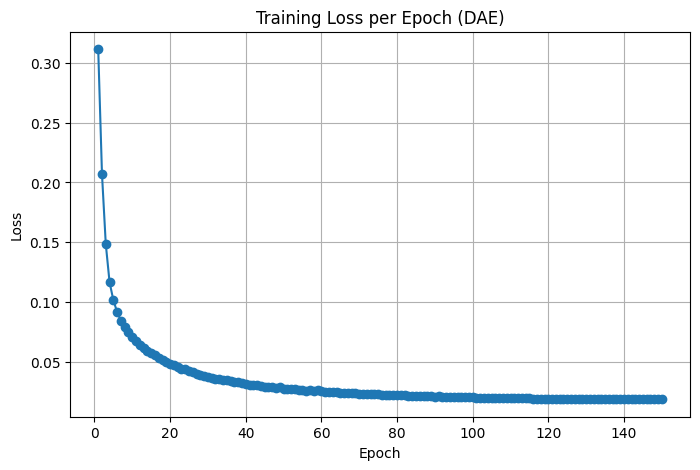

Evaluation started...
Evaluation AUC: 0.6944170096021949


In [ ]:
 if __name__ == "__main__":
    args = get_args()
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)
    set_seed(2025)
    train_and_evaluate(args)

In [ ]:
import torch
import pandas as pd
import os
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import metrics

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 로드
model = DenoisingAutoencoder(input_channels=1, dropout=0.2).to(device)
model.load_state_dict(torch.load(os.path.join(args.model_dir, args.model_path), map_location=device))
model.eval()

# 데이터 로더 준비
eval_loader, file_list = get_eval_loader(args)
criterion = torch.nn.MSELoss()

# 결과 저장 리스트
results = []
y_true, y_pred = [], []

for idx, data in enumerate(eval_loader):
    spec, anomaly_label = data[0].to(device), data[1].item()

    with torch.no_grad():
        recon_spec = model(spec)
        loss = criterion(recon_spec, spec).item()

    # 파일 이름이 존재하는지 확인 후 저장
    file_name = file_list[idx] if idx < len(file_list) else f"unknown_{idx}"
    results.append([file_name, anomaly_label, loss])
    y_true.append(1 if anomaly_label > 0 else 0)
    y_pred.append(loss)

# CSV 저장
df_results = pd.DataFrame(results, columns=["File Name", "Anomaly Label", "Loss"])
csv_file_path = os.path.join(args.result_dir, "test_results_dae_8.csv")
df_results.to_csv(csv_file_path, index=False)
print(f"테스트가 완료되었습니다. 결과는 {csv_file_path}에 저장되었습니다.")

# AUC 평가
auc = metrics.roc_auc_score(y_true, y_pred)
print(f"Evaluation AUC: {auc:.4f}")

<ipython-input-6-5aa4fd045e63>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(args.model_dir, args.model_path), map_location

테스트가 완료되었습니다. 결과는 /content/drive/MyDrive/test_results_dae_8.csv에 저장되었습니다.
Evaluation AUC: 0.7110


## 평가 데이터 바꿔서 모델 가중치 불러오기

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
import torchaudio

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 평가 데이터 경로 설정
eval_dir = "/content/ICSV31AIChallengeDataset/eval"

# 모델 생성 및 가중치 불러오기
dropout = 0.05  # args 없이 직접 설정
model = DAEModel(dropout=dropout).to(device)

checkpoint_path = "/content/drive/MyDrive/model_dae_b0319.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print("모델 가중치 로드 완료")

#######################
# 데이터 로드 함수 (디렉토리 문제 해결)
#######################
def get_eval_loader(eval_dir: str) -> tuple:
    """ 새로운 평가 데이터 로드 (오디오 파일만 포함) """
    file_list = sorted(os.listdir(eval_dir))

    # 오직 ".wav" 파일만 포함 (디렉토리 제외)
    file_list = [os.path.join(eval_dir, f) for f in file_list if f.endswith(".wav")]

    if not file_list:
        raise ValueError(f"{eval_dir}에 유효한 .wav 파일이 없습니다.")

    dataset = EvalDataset(file_list)
    return DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0), file_list

#######################
# Dataset 클래스 (STFT 변환 포함)
#######################
class EvalDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        wav_path = self.file_list[idx]
        spec = self.wav_to_log_stft(wav_path, sr=16000, n_fft=2048, win_length=512, hop_length=512, power=2.0)

        # 정답 라벨 추출 (파일명 기반)
        anomaly_label = 1 if "anomaly" in wav_path else 0

        return spec, anomaly_label

    @staticmethod
    def wav_to_log_stft(wav_path: str, sr: int, n_fft: int, win_length: int, hop_length: int, power: float) -> torch.Tensor:
        """ 오디오 파일을 로그 STFT 변환 """
        stft_transform = torchaudio.transforms.Spectrogram(
            n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=power
        )
        wav_data, _ = torchaudio.load(wav_path)
        spec = stft_transform(wav_data)
        amp_to_db = torchaudio.transforms.AmplitudeToDB()
        log_spec = amp_to_db(spec)
        log_spec = (log_spec - log_spec.mean()) / (log_spec.std() + 1e-9)  # 정규화
        return log_spec

#######################
# 평가 데이터 로드
#######################
eval_loader, file_list = get_eval_loader(eval_dir)

# 손실 함수 설정
criterion = nn.MSELoss()

# AUC 계산을 위한 리스트 초기화
y_true, y_pred = [], []

print("새로운 평가 데이터셋을 사용하여 AUC 계산 중...")
with torch.no_grad():
    for idx, data in enumerate(eval_loader):
        spec = data[0].to(device)  # 입력 데이터 (로그 STFT)
        anomaly_label = data[1]  # 정답 라벨 (정상=0, 이상=1)

        decoded = model(spec)
        loss = criterion(decoded, spec)  # MSE 기반 이상 탐지 점수

        y_true.append(anomaly_label.item())  # 정상: 0, 이상: 1
        y_pred.append(loss.item())

# AUC 점수 계산
auc_score = roc_auc_score(y_true, y_pred)
print(f"새로운 평가 데이터 ({eval_dir})에서 AUC Score: {auc_score:.4f}")


<ipython-input-7-42ab33246ee1>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


모델 가중치 로드 완료
새로운 평가 데이터셋을 사용하여 AUC 계산 중...
새로운 평가 데이터 (/content/ICSV31AIChallengeDataset/eval)에서 AUC Score: 0.7193


In [ ]:
eval_loader, file_list = get_eval_loader(eval_dir)
print(f"총 {len(file_list)}개의 .wav 파일이 있습니다.")

총 150개의 .wav 파일이 있습니다.
